# Simulation of Secure Multiparty Computation Framework

### How does it work?
It works like this: your device downloads the current model, improves it by learning from data on your phone, and then summarizes the changes as a small focused update. Only this update to the model is sent to the cloud, using encrypted communication, where it is immediately averaged with other user updates to improve the shared model. All the training data remains on your device, and no individual updates are stored in the cloud.
- https://ai.googleblog.com/2017/04/federated-learning-collaborative.html
- https://www.youtube.com/watch?v=89BGjQYA0uE Desde el 13:50 Hasta 19:26

Hi,
You recently answered me in the OpenFL githhub with 3 examples from your repos. I want to connect with you as I see your profile very interesting and with great knowledge about FL. I would like to connect with you as I am developing my university thesis and I think I could learn a lot from you.

## Libraries

In [ ]:
import torch
import os
import glob
import torchvision
import cv2

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import openfl.native as fx
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from openfl.interface.interactive_api.federation import Federation
from openfl.interface.interactive_api.experiment import FLExperiment
from openfl.federated import FederatedModel,FederatedDataSet

In [2]:
client_id = 'api'
cert_dir = 'cert'
director_node_fqdn = 'localhost'
director_port = '50051'

federation = Federation(
    client_id=client_id,
    director_node_fqdn=director_node_fqdn,
    director_port=director_port, 
    tls=False
)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1675875930.612000000","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1675875930.612000000","description":"failed to connect to all addresses","file":"src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}"
>

## Data Preparation

In [2]:
#Using the transforms module in the torchvision module, we define a set of functions that perform data augmentation on our dataset to obtain more data.#
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((150,150)),
    transforms.CenterCrop(150),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((150,150)),
    transforms.CenterCrop(150),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'valid_transforms' : transforms.Compose([
    transforms.Resize((150,150)),
    transforms.CenterCrop(150),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}
trans = ['train_transforms','valid_transforms','test_transforms']
path = "C:/Users/clash/Desktop/4/TFG/chest_xray/"
categories = ['train','val','test']

In [3]:
dataset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}
dataset_sizes = {x : len(dataset[x]) for x in ["test","val","test"]}
num_threads = 4

#By passing a dataset instance into a DataLoader module, we create dataloader which generates images in batches.
dataloaders =  {x : torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=False, num_workers=num_threads)
               for x in categories}

In [4]:
train_size = int(0.8 * len(dataset['train']))
val_size = len(dataset['train']) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset['train'], [train_size, val_size])

train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)

val_sampler = torch.utils.data.sampler.RandomSampler(val_dataset)

In [5]:
#from sklearn.model_selection import StratifiedShuffleSplit

# create a stratified shuffle split
#splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the data indices
#train_indices, val_indices = next(splitter.split(range(len(dataset['train'])), dataset['train'].targets))

# create a custom sampler for the training set
#train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

# create a custom sampler for the validation set
#val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

# update the dataloaders dictionary
dataloaders['train'] = torch.utils.data.DataLoader(dataset['train'], batch_size=32,
                                                   num_workers=num_threads, sampler=train_sampler)
dataloaders['val'] = torch.utils.data.DataLoader(dataset['train'], batch_size=32, 
                                                 num_workers=num_threads, sampler=val_sampler)

In [6]:
# create variables to store the features and labels
train_features, train_labels = torch.stack([data for data, label in dataloaders['train']]), torch.tensor([label for data, label in dataloaders['train']])
val_features, val_labels = torch.stack([data for data, label in dataloaders['val']]), torch.tensor([label for data, label in dataloaders['val']])
test_features, test_labels = torch.stack([data for data, label in dataloaders['test']]), torch.tensor([label for data, label in dataloaders['test']])

RuntimeError: stack expects each tensor to be equal size, but got [32, 3, 150, 150] at entry 0 and [12, 3, 150, 150] at entry 130

In [7]:
counts = {'train': {'true': 0, 'false': 0}, 'val': {'true': 0, 'false': 0}, 'test': {'true': 0, 'false': 0}}

# iterate through the dataloaders and count the number of true and false targets
for split in ["train","val","test"]:
    for data, target in dataloaders[split]:
        if target == 1:
            counts[split]['true'] += 1
        else:
            counts[split]['false'] += 1
# print the counts
print("The targets are distributed like this: \n", counts)

The targets are distributed like this: 
 {'train': {'true': 2831, 'false': 1341}, 'val': {'true': 0, 'false': 1044}, 'test': {'true': 390, 'false': 234}}


NameError: name 'x' is not defined

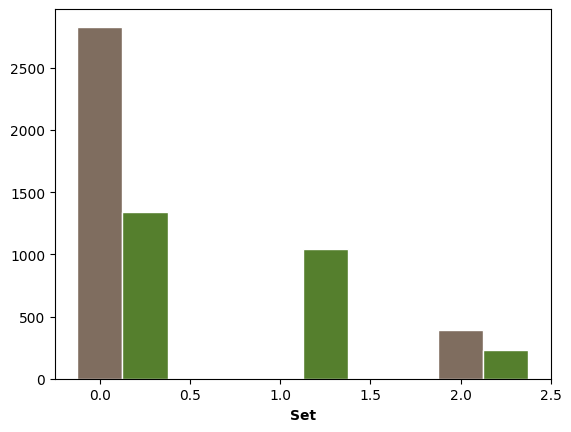

In [9]:
# extract the counts from the dictionary
train_true = counts['train']['true']
train_false = counts['train']['false']
val_true = counts['val']['true']
val_false = counts['val']['false']
test_true = counts['test']['true']
test_false = counts['test']['false']

# create the bar plot

fig, ax = plt.subplots()

barWidth = 0.25

bars1 = [train_true, val_true, test_true]
bars2 = [train_false, val_false, test_false]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='True')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='False')

plt.xlabel("Set", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], x)
plt.ylabel("Number of samples", fontweight='bold')
plt.legend()
plt.show()

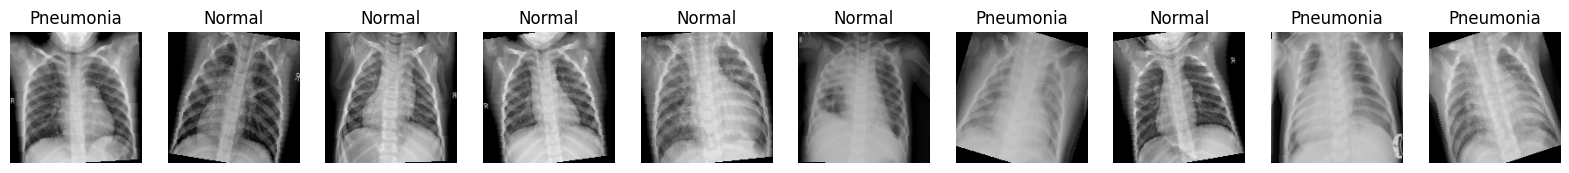

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(n):
    fig, axs = plt.subplots(1, n, figsize=(20,20))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(n):
        inp = train_features[i].numpy().transpose((1,2,0))
        inp = std*inp + mean
        axs[i].imshow((inp * 255).astype(np.uint8))
        if train_labels[i] == 1:
            axs[i].set_title("Pneumonia")
        else:
            axs[i].set_title("Normal")
        axs[i].axis('off')
    plt.show()

plot_images(10)


Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [21]:
#Setup default workspace, logging, etc.
fx.init('torch_cnn_mnist', log_level='METRIC', log_file='./spam_metric.log') #'C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl-workspace'
#fx.run_experiment(experiment_collaborators, override_config={"aggregator.settings.rounds_to_train": 20})

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── .workspace
├── agg_to_col_one_signed_cert.zip
├── agg_to_col_two_signed_cert.zip
├── cert
├── data
│   └── MNIST
│       ├── processed
│       └── raw
├── director.yaml
├── envoy_config.yaml
├── final_pytorch_model
├── lightning_logs
│   ├── version_0
│   │   ├── events.out.tfevents.1674498751.LAPTOP-S11BJ6U7.9884.0
│   │   └── hparams.yaml
│   ├── version_1
│   │   ├── events.out.tfevents.1674498850.LAPTOP-S11BJ6U7.9884.1
│   │   └── hparams.yaml
│   ├── version_10
│   │   ├── events.out.tfevents.1674503091.LAPTOP-S11BJ6U7.9884.10
│   │   └── hparams.yaml
│   ├── version_11
│   │   ├── events.out.tfevents.1674503246.LAPTOP-S11BJ6U7.9884.11
│   │   └── hparams.yaml
│   ├── version_12
│   │   ├── events.out.tfevents.1674503343.LAPTOP-S11BJ6U7.9884.12
│   │   └── hparams.yaml
│   ├── version_13
│   │   ├── events.out.tfevents.1674503535.LAPTOP-S11BJ6U7.9884.13
│   │   └── hparams

In [56]:
img_shape = (3, 150, 150)
feature_shape = 3
classes = 2
bathc_size = 32

#fl_data = FederatedDataSet(train_features, np.array(train_labels), val_features, 
#          np.array(val_labels), batch_size=32,num_classes=classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=3, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * x.shape[2] * x.shape[3])
        x = self.dropout(x)
        self.fc1 = nn.Linear(x.shape[1], 128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        self.fc2 = nn.Linear(128, classes)
        x = self.fc2(x)
        return x

    #def training_step(self, batch, batch_idx):
        features, labels = batch
        labels = labels.clone().detach()
        labels = labels.long()
        output = self(features)
        _, predicted = torch.max(output.data, 1)
        accuracy = (predicted == labels).sum().item() / len(labels)
        loss = loss_fn(output, labels)
        logs = {'loss': loss, 'accuracy': accuracy, 'batch': batch_idx}
        return {'loss': loss, 'log': logs}

    #def validation_step(self, batch, batch_idx):
        features, labels = batch
        labels = labels.clone().detach()
        labels = labels.long()
        output = self(features)
        _, predicted = torch.max(output.data, 1)
        accuracy = (predicted == labels).sum().item() / len(labels)
        loss = loss_fn(output, labels)
        self.log('val_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': accuracy}

    #def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': logs}  

    #def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
       
    #def test_step(self, batch, batch_idx):
        features, labels = batch
        labels = labels.long()
        output = self(features)
        _, preds = torch.max(output, dim=1)
        acc = (preds == labels).float()
        return {'test_acc': acc}
       
    #def test_epoch_end(self, outputs):
        acc = torch.cat([x['test_acc'] for x in outputs])
        avg_acc = torch.mean(acc)
        logs = {'test_acc': avg_acc}
        return logs

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
for epoch in range(2):
    for i, data in enumerate(dataloaders['train'], 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}")

Epoch: 0, Iteration: 0, Loss: 0.7044558525085449
Epoch: 0, Iteration: 100, Loss: 0.724424421787262
Epoch: 1, Iteration: 0, Loss: 0.6612325310707092
Epoch: 1, Iteration: 100, Loss: 0.7063031196594238


In [57]:
for epoch in range(50):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(dataloaders['train'], 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        #_, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (i + 1) % 32 == 0:
            print('Epoch: %d | Batch: %5d | Loss: %.3f' %
                  (epoch + 1, (i + 1)//32, running_loss / 32))
            running_loss = 0.0

            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for data in dataloaders['val']:
                    images, labels = data
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print('Accuracy of the network on the val images: %d %%' % (
                accuracy))

Epoch: 1 | Batch:     1 | Loss: 0.695
Accuracy of the network on the val images: 44 %
Epoch: 1 | Batch:     2 | Loss: 0.695
Accuracy of the network on the val images: 59 %
Epoch: 1 | Batch:     3 | Loss: 0.696
Accuracy of the network on the val images: 45 %
Epoch: 1 | Batch:     4 | Loss: 0.698
Accuracy of the network on the val images: 51 %
Epoch: 2 | Batch:     1 | Loss: 0.690
Accuracy of the network on the val images: 62 %
Epoch: 2 | Batch:     2 | Loss: 0.692
Accuracy of the network on the val images: 43 %
Epoch: 2 | Batch:     3 | Loss: 0.695


KeyboardInterrupt: 

In [21]:
# Define the model and move it to CPU
model = Net()
model = model.to('cpu')

# Get the data loader
dataloader = dataloaders['train']  # your dataloader

# Make predictions
all_predictions = []
all_scores = []
model.eval() # set model to evaluation mode
with torch.no_grad(): # turn off gradients for evaluation
    for inputs, labels in dataloader:
        inputs = inputs.to('cpu')
        outputs = model(inputs)
        _, predictions = torch.max(outputs, dim=1)
        scores = torch.softmax(outputs, dim=1)
        all_predictions.extend(predictions.tolist())
        all_scores.extend(scores.tolist())

In [35]:
torch.tensor(all_scores)

tensor([[0.5338, 0.4662],
        [0.5457, 0.4543],
        [0.5356, 0.4644],
        ...,
        [0.5131, 0.4869],
        [0.5239, 0.4761],
        [0.5106, 0.4894]])

In [36]:
all_scores = torch.tensor(all_scores) # the predictions of your model, either as a tensor or as a list
all_labels = train_labels # the ground-truth labels, in the same format as all_scores

# convert the scores to class predictions (e.g. the class with the highest score)
_, preds = torch.max(all_scores, dim=1)

# compare the predicted classes to the ground-truth labels
correct_predictions = preds == all_labels

# count the number of correct predictions
num_correct = correct_predictions.sum().item()

# compute the total accuracy by dividing the number of correct predictions by the total number of samples
accuracy = num_correct / len(all_labels)

In [37]:
accuracy

0.5225311601150527

Here we can define metric logging function. It should has the following signature described below. You can use it to write metrics to tensorboard or some another specific logging.

In [28]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./logs/cnn_mnist', flush_secs=5)


def write_metric(node_name, task_name, metric_name, metric, round_number):
    writer.add_scalar("{}/{}/{}".format(node_name, task_name, metric_name),
                      metric, round_number)

In [31]:

#Create a federated model using the pytorch class, lambda optimizer function, and loss function
fl_model = FederatedModel(build_model = Net, optimizer = optimizer, data_loader = fl_data)

[03:25:26] WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=239231;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py\utils.py]8;;\:]8;id=520056;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py#170\170]8;;\

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [32]:
collaborator_models = fl_model.setup(num_collaborators=2)
collaborators = {'one':collaborator_models[0],'two':collaborator_models[1]}#, 'three':collaborator_models[2]}

[03:25:31] WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=335724;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py\utils.py]8;;\:]8;id=321122;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py#170\170]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=610017;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py\utils.py]8;;\:]8;id=813093;file://C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\utilities\utils.py#170\170]8;;\

In [25]:
#Original MNIST dataset
print(f'Original training data size: {len(train_features)}')
print(f'Original validation data size: {len(val_features)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')

Original training data size: 4172
Original validation data size: 1044

Collaborator one's training data size: 2086
Collaborator one's validation data size: 522

Collaborator two's training data size: 2086
Collaborator two's validation data size: 522



We can see the current plan values by running the `fx.get_plan()` function

In [55]:
 #Get the current values of the plan. Each of these can be overridden
print(fx.get_plan())

{
    "aggregator.settings.best_state_path": "save/best.pbuf",
    "aggregator.settings.db_store_rounds": 2,
    "aggregator.settings.init_state_path": "save/init.pbuf",
    "aggregator.settings.last_state_path": "save/last.pbuf",
    "aggregator.settings.rounds_to_train": 10,
    "aggregator.settings.write_logs": true,
    "aggregator.template": "openfl.component.Aggregator",
    "assigner.settings.task_groups.0.name": "train_and_validate",
    "assigner.settings.task_groups.0.percentage": 1.0,
    "assigner.settings.task_groups.0.tasks.0": "aggregated_model_validation",
    "assigner.settings.task_groups.0.tasks.1": "train",
    "assigner.settings.task_groups.0.tasks.2": "locally_tuned_model_validation",
    "assigner.template": "openfl.component.RandomGroupedAssigner",
    "collaborator.settings.db_store_rounds": 1,
    "collaborator.settings.delta_updates": false,
    "collaborator.settings.opt_treatment": "RESET",
    "collaborator.template": "openfl.component.Collaborator",
    "

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [33]:
# Run experiment, return trained FederatedModel

final_fl_model = fx.run_experiment(collaborators)#, override_config={
    #'aggregator.settings.rounds_to_train': 5
    #'aggregator.settings.log_metric_callback': write_metric,
#})

C:\Users\clash\AppData\Roaming\Python\Python37\site-packages\openfl\federated\task\runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [20]:
#Save final model
final_fl_model.save_native('final_pytorch_model')

Signature:
final_fl_model.save_native(
    filepath,
    model_state_dict_key='model_state_dict',
    optimizer_state_dict_key='optimizer_state_dict',
    **kwargs,
)
Docstring:
Save model and optimizer states in a picked file specified by the         filepath. model_/optimizer_state_dicts are stored in the keys provided.         Uses pt.save().

Args:
    filepath (string)                 : Path to pickle file to be
                                        created by pt.save().
    model_state_dict_key (string)     : key for model state dict
                                        in pickled file.
    optimizer_state_dict_key (string) : key for optimizer state
                                        dict in picked file.
    kwargs                            : unused

Returns:
    None
File:      c:\users\clash\appdata\roaming\python\python37\site-packages\openfl\federated\task\runner_pt.py
Type:      method
